# 1. Load libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.style.use('ggplot')

# 2. Load data

In [3]:
original_df = pd.read_csv('data/uber_peru_2010.csv', delimiter=';')

original_df.info()
original_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23111 entries, 0 to 23110
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   journey_id        23111 non-null  object 
 1   user_id           23111 non-null  object 
 2   driver_id         19726 non-null  object 
 3   taxi_id           19726 non-null  object 
 4   icon              23111 non-null  object 
 5   start_type        23111 non-null  object 
 6   start_at          23111 non-null  object 
 7   start_lat         23111 non-null  object 
 8   start_lon         23111 non-null  object 
 9   end_at            22835 non-null  object 
 10  end_lat           23111 non-null  object 
 11  end_lon           23111 non-null  object 
 12  end_state         23099 non-null  object 
 13  driver_start_lat  19621 non-null  object 
 14  driver_start_lon  19621 non-null  object 
 15  arrived_at        17716 non-null  object 
 16  currency          23111 non-null  object

,journey_id,user_id,driver_id,taxi_id,icon,start_type,start_at,start_lat,start_lon,end_at,...,price_distance,price_duration,distance,duration,cost,cost_distance,cost_duration,source,driver_score,rider_score
0,23a1406fc6a11d866e3c82f22eed4d4c,0e9af5bbf1edfe591b54ecdfd7e91e26,583949a89a9ee17d19e3ca4f137b6b4c,b12f4f09c783e29fe0d0ea624530db56,executive,asap,16/11/2010 16:44,"-12,13983536","-77,02355957",16/11/2010 17:29,...,3626.0,195.0,11331.0,234.0,0.0,0.0,0.0,iPhone,5.0,5.0
1,dd2af4715d0dc16eded53afc0e243577,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,01/06/2010 0:34,"-12,13874817","-76,99536133",01/06/2010 0:37,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,iPhone,NaN,NaN
2,dd91e131888064bf7df3ce08f3d4b4ad,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,31/05/2010 5:01,"-12,12453079","-77,02780151",31/05/2010 5:04,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,iPhone,NaN,NaN
3,dd2af4715d0dc16eded53afc0e2466d0,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,01/06/2010 0:29,"-12,13885117","-76,99530029",01/06/2010 0:32,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,iPhone,NaN,NaN
4,85b7eabcf5d84e42dc7629b7d27781af,56772d544fdfa589a020a1ff894a86f7,d665fb9f75ef5d9cd0fd89479380ba78,0accdd3aa5a322f4129fa20b53278c69,executive,reserved,11/09/2010 23:55,"-12,08995438","-76,92626953",12/09/2010 1:07,...,7665.0,562.0,30270.0,715.0,6173.0,5756.0,417.0,iPhone,4.0,5.0


# 3. Save original data and make a copy for doing feature engineer

In [4]:
df = original_df.copy()

# 4. Feature engineering

The idea of feature engineering for `churn prediction model` mainly based on `RFM model`:
* `R` - `Recency`: How recent was the customer's last behavior? 
* `F` - `Frequency`: How often did this customer perform that behavior in a given period?
* `M` - `Monetary`: How much money did the customer spend in a given period?

And `data labeling` method refered from this [publication](https://www.atlantis-press.com/proceedings/mecae-18/25893766) as below:

<br>
<div align="center">
<img src="Images/data_labeling_method.png" width="600" height="200">
</div>
<br>

Select the transactional data from `2010-01-01` to `2010-09-30` as the **observation period**, from `2010-10-01` to `2010-12-31` as the **forecast period**:
* If the riders did not have any `drop off` trip during the forecast period, such riders are considered to be churn within `3-month threshold`, marked  as `1`
* If the rider has at least one `drop off` trip during the forecast period, such riders are NOT considered to be churn, marked as `0`.


## `4.1`. Preprocessing

In [5]:
df['start_at'] = pd.to_datetime(df['start_at']) #format='%d/%m/%Y %H:%M'

C:\Users\ACER\AppData\Local\Temp\ipykernel_9260\1841626163.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['start_at'] = pd.to_datetime(df['start_at']) #format='%d/%m/%Y %H:%M'


## `4.2`. Divide the transactional data into `observation` and `forecast` period.

`observation` data will be used for feature engineering and `forecast` data will be used for churn labeling.

In [6]:
# Observation period is ranged from 2010-01-01 to 2010-09-30
observation_df = df[df['start_at'] < '2010-10-01']
observation_df.shape

(13537, 28)

In [7]:
# Get a list of customers in the observation period
obs_customers = observation_df['user_id'].unique().tolist()
print('There are {} customers in the observation period'.format(len(obs_customers)))

There are 973 customers in the observation period


In [8]:
# Get transactional data for those observation customers in the forecast period from 2010-10-01 to 2010-12-31
forecast_df = df[(df['start_at'] >= '2010-10-01')&(df['user_id'].isin(obs_customers))]
print('There are {} customers in the forecast period'.format(forecast_df['user_id'].nunique()))

There are 436 customers in the forecast period


## `4.3`. Handle NA/outliers for columns of interest

* Out of all numeric columns, only take four columns `price`, `distance`, `duration` and `rider_score` for feature engineering.
* Because our data size is quite small for modeling, we will try to compute missing value as many as possible

In [9]:
print('% of missing value in each column of observation_df:')
observation_df.isna().sum()*100/observation_df.shape[0]

% of missing value in each column of observation_df:


journey_id           0.000000
user_id              0.000000
driver_id           14.818645
taxi_id             14.818645
icon                 0.000000
start_type           0.000000
start_at             0.000000
start_lat            0.000000
start_lon            0.000000
end_at               1.388786
end_lat              0.000000
end_lon              0.000000
end_state            0.088646
driver_start_lat    15.490877
driver_start_lon    15.490877
arrived_at          24.702667
currency             0.000000
price                2.009308
price_distance      16.842727
price_duration      16.842727
distance             1.322302
duration             1.322302
cost                 9.086208
cost_distance       27.317722
cost_duration       27.317722
source               0.871685
driver_score        63.411391
rider_score         34.734432
dtype: float64

### `4.3.1`. `end_state`

- Only about 0.09% of records are missing.
- Because price and cost for these records of missing are also NaN, these trips can only be failed.
- Compute missing values by the most frequency value of failed trips (`end_state` = `rider cancel`, `driver cancel`, `no show`, `not found`, `failure`).

In [10]:
# All records with missing value in end_state
observation_df[observation_df['end_state'].isnull()][['end_state',\
                                                      'price','price_distance','price_duration',
                                                      'cost','cost_distance','cost_duration']]
# Because price and cost for these records of missing are also NaN, these trips can't be drop off

,end_state,price,price_distance,price_duration,cost,cost_distance,cost_duration
1594,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2041,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5877,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7033,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Compute missing values by the most frequency value of failed trips
most_fre_failed_trip = observation_df[observation_df['end_state'] != 'drop off']['end_state'].value_counts().index[0]
print('The most frequency end state of failed trips is "rider cancel"')

The most frequency end state of failed trips is "rider cancel"


In [12]:
# Fill missing value for end_state
observation_df['end_state'].fillna(most_fre_failed_trip, inplace = True)

C:\Users\ACER\AppData\Local\Temp\ipykernel_9260\2026963526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observation_df['end_state'].fillna(most_fre_failed_trip, inplace = True)


In [13]:
end_state_NA = observation_df['end_state'].isna().sum()
print('There is {} missing value in the end state column'.format(end_state_NA))

There is 0 missing value in the end state column


### `4.3.2`. `price`
- Only about 2% of records are missing.
- Because missing values of price belongs to both drop off and NOT drop off trips, replace missing values of drop off trips by median due to skewed distribution and outliers, and replace mising value of NOT drop off trips with zero.

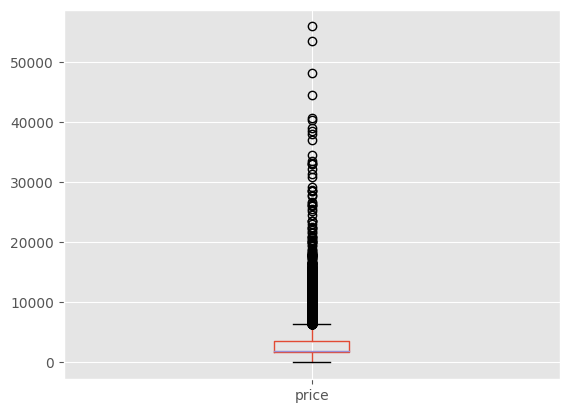

In [14]:
observation_df[['price']].boxplot();
# Lots of outliers present in the 'price' column

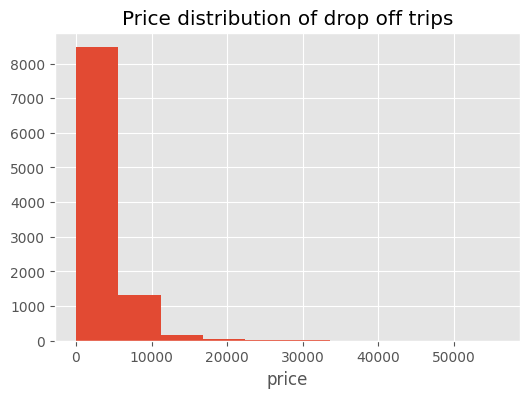

In [15]:
observation_df[observation_df['end_state']=='drop off']['price'].hist(figsize=(6,4))
plt.xlabel('price')
plt.title('Price distribution of drop off trips');
# This is a right skewed distribution

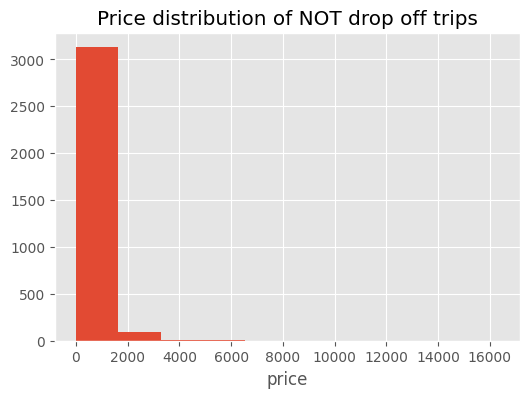

In [16]:
observation_df[observation_df['end_state']!='drop off']['price'].hist(figsize=(6,4))
plt.xlabel('price')
plt.title('Price distribution of NOT drop off trips');
# This is a right skewed distribution

In [17]:
observation_df[observation_df['price'].isnull()]['end_state'].value_counts()

end_state
failure          165
rider cancel     103
drop off           3
driver cancel      1
Name: count, dtype: int64

In [18]:
# We can see that missing values of price belongs to both drop off and NOT drop off trips, 
    ## so replace missing values of drop off trips by median due to skewed distribution and outliers
median_drop_off_price = observation_df[observation_df['end_state']=='drop off']['price'].median()
observation_df[observation_df['end_state']=='drop off'].fillna(median_drop_off_price, inplace=True)
    ## replace missing value of NOT drop off with zero
observation_df['price'].fillna(0, inplace=True)

C:\Users\ACER\AppData\Local\Temp\ipykernel_9260\226773589.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observation_df[observation_df['end_state']=='drop off'].fillna(median_drop_off_price, inplace=True)
C:\Users\ACER\AppData\Local\Temp\ipykernel_9260\226773589.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observation_df['price'].fillna(0, inplace=True)


In [19]:
print('There is {} missing value in the price column'.format(observation_df['price'].isna().sum()))

There is 0 missing value in the price column


### `4.3.3`. `distance`
- Only about 1.3% of records are missing.
- Because all missing values of distance belong to NOT drop off trips, fill NA with zero

In [20]:
# All missing values of distance belong to NOT drop off trips
observation_df[observation_df['distance'].isnull()]['end_state'].unique()

array(['rider cancel', 'failure'], dtype=object)

In [21]:
# fill NA with zero
observation_df['distance'].fillna(0, inplace = True)

C:\Users\ACER\AppData\Local\Temp\ipykernel_9260\231064254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observation_df['distance'].fillna(0, inplace = True)


In [22]:
print('There is {} missing value in the distance column'.format(observation_df['distance'].isna().sum()))

There is 0 missing value in the distance column


### `4.3.4`. `duration`
- Only about 1.3% of records are missing.
- Because all missing values of distance belong to NOT drop off trips, fill NA with zero

In [23]:
# All missing values of duration belong to NOT drop off trips
observation_df[observation_df['duration'].isnull()]['end_state'].unique()

array(['rider cancel', 'failure'], dtype=object)

In [24]:
# fill NA with zero
observation_df['duration'].fillna(0, inplace = True)

C:\Users\ACER\AppData\Local\Temp\ipykernel_9260\3916852875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observation_df['duration'].fillna(0, inplace = True)


In [25]:
print('There is {} missing value in the duration column'.format(observation_df['duration'].isna().sum()))

There is 0 missing value in the duration column


## `4.4`. Desriptive statistics

### `4.4.1`. Numeric columns

In [26]:
observation_df[['price','cost','distance','duration','rider_score']].describe().applymap(lambda x: f"{x:0.3f}")

,price,cost,distance,duration,rider_score
count,13537.000,12307.000,13537.000,13537.000,8835.000
mean,2688.198,2591.050,7490.249,643.491,4.689
std,3129.966,16655.139,120843.843,1912.529,1.032
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,5.000
50%,1836.000,1700.000,4581.000,193.000,5.000
75%,3514.000,2454.000,9210.000,622.000,5.000
max,55974.000,525000.000,14037219.000,83807.000,5.000


### `4.4.2`. Catergorical columns

In [27]:
observation_df[['end_state','start_type']].describe()

,end_state,start_type
count,13537,13537
unique,6,3
top,drop off,asap
freq,10035,8622


## `4.5`. Transform data

The idea of feature engineering for `churn prediction model` mainly based on `RFM model`:
* `R` - `Recency`: How recent was the customer's last behavior? 
* `F` - `Frequency`: How often did this customer perform that behavior in a given period?
* `M` - `Monetary`: How much money did the customer spend in a given period?

In [28]:
# Filter data for feature engineering
obs_df = observation_df.copy()
obs_df = obs_df[~obs_df['end_state'].isin(['no show','not found'])]

In [29]:
# Set date of calulation
build_date = dt.datetime(2011,1,1)
build_date

datetime.datetime(2011, 1, 1, 0, 0)

In [30]:
feat_df = obs_df.assign(
                        days_passed_last_dropoff_trip = obs_df[obs_df['end_state']=='drop off']['start_at'],
                        days_passed_last_failed_trip = obs_df[obs_df['end_state']=='failure']['start_at'],
                        days_passed_last_rider_cancel_trip = obs_df[obs_df['end_state']=='rider cancel']['start_at'],
                        days_passed_last_driver_cancel_trip = obs_df[obs_df['end_state']=='driver cancel']['start_at'],
                        numbers_of_dropoff_trips_last9m = obs_df[obs_df['end_state']=='drop off']['journey_id'],
                        numbers_of_failed_trips_last9m =  obs_df[obs_df['end_state']=='failure']['journey_id'],
                        numbers_of_trips_canceled_by_rider_last9m = obs_df[obs_df['end_state']=='rider cancel']['journey_id'],
                        numbers_of_trips_canceled_by_driver_last9m = obs_df[obs_df['end_state']=='driver cancel']['journey_id'],
                        numbers_of_trips_charged_cancelation_fee_last9m = obs_df[(obs_df['end_state']!='drop off')&(obs_df['price']>0)]['journey_id'],
                        total_cancelation_fee_last9m = obs_df[(obs_df['end_state']!='drop off')&(obs_df['price']>0)]['price'],
                        avg_distance_last9m = obs_df['distance'],
                        avg_duration_last9m = obs_df['duration']
                       )\
                .groupby('user_id')\
                .agg({
                      'start_at': lambda x: (build_date - x.max()).days,
                      'days_passed_last_dropoff_trip': lambda x: (build_date - x.max()).days,
                      'days_passed_last_failed_trip': lambda x: (build_date - x.max()).days,
                      'days_passed_last_rider_cancel_trip': lambda x: (build_date - x.max()).days,
                      'days_passed_last_driver_cancel_trip': lambda x: (build_date - x.max()).days,
                      'numbers_of_dropoff_trips_last9m': lambda x: x.count(),
                      'numbers_of_failed_trips_last9m': lambda x: x.count(),
                      'numbers_of_trips_canceled_by_rider_last9m': lambda x: x.count(),
                      'numbers_of_trips_canceled_by_driver_last9m': lambda x: x.count(),
                      'numbers_of_trips_charged_cancelation_fee_last9m': lambda x: x.count(),
                      'price': lambda x: x.sum(),
                      'total_cancelation_fee_last9m': lambda x: x.sum(),
                      'distance': lambda x: x.sum(),
                      'duration': lambda x: x.sum(),
                      'avg_distance_last9m': lambda x: x.median(skipna=True),
                      'avg_duration_last9m': lambda x: x.median(skipna=True),
                      'rider_score': lambda x: x.mean(skipna=True)
                      })\
                .rename(columns={'start_at':'days_passed_last_trip',
                                 'price': 'total_spending_last9m',
                                 'distance': 'total_distance_last9m',
                                 'duration': 'total_duration_last9m',
                                 'rider_score': 'avg_rider_score_last9m'})

feat_df['is_last_trip_dropoff'] = np.where(feat_df['days_passed_last_dropoff_trip']==feat_df['days_passed_last_trip'],1,0)
feat_df['is_last_trip_failed'] = np.where(feat_df['days_passed_last_failed_trip']==feat_df['days_passed_last_trip'],1,0)
feat_df['is_last_trip_canceled_by_rider'] = np.where(feat_df['days_passed_last_rider_cancel_trip']==feat_df['days_passed_last_trip'],1,0)
feat_df['is_last_trip_canceled_by_driver'] = np.where(feat_df['days_passed_last_driver_cancel_trip']==feat_df['days_passed_last_trip'],1,0)

feat_df = feat_df.reset_index()

In [31]:
feat_df

,user_id,days_passed_last_trip,days_passed_last_dropoff_trip,days_passed_last_failed_trip,days_passed_last_rider_cancel_trip,days_passed_last_driver_cancel_trip,numbers_of_dropoff_trips_last9m,numbers_of_failed_trips_last9m,numbers_of_trips_canceled_by_rider_last9m,numbers_of_trips_canceled_by_driver_last9m,...,total_cancelation_fee_last9m,total_distance_last9m,total_duration_last9m,avg_distance_last9m,avg_duration_last9m,avg_rider_score_last9m,is_last_trip_dropoff,is_last_trip_failed,is_last_trip_canceled_by_rider,is_last_trip_canceled_by_driver
0,00cb8ad6a0f7214d002e3ded6b7c9b80,122,122.0,NaN,NaN,NaN,7,0,0,0,...,0.0,88349.0,1723.0,12001.0,204.0,4.714286,1,0,0,0
1,00cb8ad6a0f7214d002e3ded6b7de012,100,100.0,NaN,296.0,NaN,5,0,2,0,...,3726.0,42793.0,5722.0,8344.0,148.0,4.000000,1,0,0,0
2,00cb8ad6a0f7214d002e3ded6b7eb91b,316,316.0,NaN,NaN,NaN,1,0,0,0,...,0.0,15716.0,406.0,15716.0,406.0,5.000000,1,0,0,0
3,0194b4a5c9e41bfd35f9168423f7b7b4,314,NaN,NaN,314.0,NaN,0,0,2,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,1,0
4,0194b4a5c9e41bfd35f9168423fa2857,136,136.0,NaN,174.0,NaN,23,0,11,0,...,0.0,125130.0,12231.0,5123.5,89.0,4.863636,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,ff1cb10b9edf79369742a37ce5d8d6f6,273,273.0,NaN,NaN,NaN,1,0,0,0,...,0.0,4776.0,76.0,4776.0,76.0,NaN,1,0,0,0
952,ff5c924e0b630fd7c019a4234053c385,136,136.0,NaN,NaN,NaN,1,0,0,0,...,0.0,13720.0,61.0,13720.0,61.0,4.000000,1,0,0,0
953,ff5c924e0b630fd7c019a42340593ee2,259,259.0,NaN,NaN,NaN,1,0,0,0,...,0.0,3370.0,193.0,3370.0,193.0,5.000000,1,0,0,0
954,ff5c924e0b630fd7c019a42340594b55,92,92.0,NaN,111.0,112.0,30,0,7,1,...,800.0,224330.0,11363.0,4925.0,207.0,3.766667,1,0,0,0


## `4.6`. Label data

* If the riders did not have any `drop off` trip during the forecast period, such riders are considered to be churn within `3-month threshold`, marked  as `1`
* If the rider has at least one `drop off` trip during the forecast period, such riders are NOT considered to be churn, marked as `0`.

In [32]:
# Get number of dropoff trips in the forecast period
label_df = forecast_df[forecast_df['end_state']=='drop off'].groupby('user_id')['journey_id']\
                                                            .count()\
                                                            .reset_index()\
                                                            .rename(columns={'journey_id':'number_of_dropoff_trips_forecast_period'})
label_df

,user_id,number_of_dropoff_trips_forecast_period
0,0221e01fd79a9e76808595048df20efd,8
1,0234eb5f7e99d581c72052f0a86abaee,1
2,0234eb5f7e99d581c72052f0a86bdd4a,3
3,028c0aa5c5f7e32a652df0a733283325,3
4,056e782066df516f734d0bbc2465ba2b,4
...,...,...
407,fd3831b43f038c9ee0e840c18baa5793,6
408,fd3831b43f038c9ee0e840c18bc56ea0,19
409,feceb9ec89bf76685af19ab5f8659b84,2
410,ff1cb10b9edf79369742a37ce5d5f898,5


In [33]:
# Append and transform label in feat_df
final_feat_df = feat_df.merge(label_df, how='left', on='user_id')
final_feat_df['label'] = np.where(final_feat_df['number_of_dropoff_trips_forecast_period']>0, 0, 1).astype(str)
final_feat_df.drop(['number_of_dropoff_trips_forecast_period'], axis=1, inplace=True)
final_feat_df

,user_id,days_passed_last_trip,days_passed_last_dropoff_trip,days_passed_last_failed_trip,days_passed_last_rider_cancel_trip,days_passed_last_driver_cancel_trip,numbers_of_dropoff_trips_last9m,numbers_of_failed_trips_last9m,numbers_of_trips_canceled_by_rider_last9m,numbers_of_trips_canceled_by_driver_last9m,...,total_distance_last9m,total_duration_last9m,avg_distance_last9m,avg_duration_last9m,avg_rider_score_last9m,is_last_trip_dropoff,is_last_trip_failed,is_last_trip_canceled_by_rider,is_last_trip_canceled_by_driver,label
0,00cb8ad6a0f7214d002e3ded6b7c9b80,122,122.0,NaN,NaN,NaN,7,0,0,0,...,88349.0,1723.0,12001.0,204.0,4.714286,1,0,0,0,1
1,00cb8ad6a0f7214d002e3ded6b7de012,100,100.0,NaN,296.0,NaN,5,0,2,0,...,42793.0,5722.0,8344.0,148.0,4.000000,1,0,0,0,1
2,00cb8ad6a0f7214d002e3ded6b7eb91b,316,316.0,NaN,NaN,NaN,1,0,0,0,...,15716.0,406.0,15716.0,406.0,5.000000,1,0,0,0,1
3,0194b4a5c9e41bfd35f9168423f7b7b4,314,NaN,NaN,314.0,NaN,0,0,2,0,...,0.0,0.0,0.0,0.0,NaN,0,0,1,0,1
4,0194b4a5c9e41bfd35f9168423fa2857,136,136.0,NaN,174.0,NaN,23,0,11,0,...,125130.0,12231.0,5123.5,89.0,4.863636,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,ff1cb10b9edf79369742a37ce5d8d6f6,273,273.0,NaN,NaN,NaN,1,0,0,0,...,4776.0,76.0,4776.0,76.0,NaN,1,0,0,0,1
952,ff5c924e0b630fd7c019a4234053c385,136,136.0,NaN,NaN,NaN,1,0,0,0,...,13720.0,61.0,13720.0,61.0,4.000000,1,0,0,0,1
953,ff5c924e0b630fd7c019a42340593ee2,259,259.0,NaN,NaN,NaN,1,0,0,0,...,3370.0,193.0,3370.0,193.0,5.000000,1,0,0,0,1
954,ff5c924e0b630fd7c019a42340594b55,92,92.0,NaN,111.0,112.0,30,0,7,1,...,224330.0,11363.0,4925.0,207.0,3.766667,1,0,0,0,1


## `4.7`. Handle missing value for features

- Before passing the data into machine learning model, we need to get columns with null value filled up. 
- Because the dataset size is quite small, we will try to take a very naive approach to fill NA with zero.

In [34]:
final_feat_df.isna().sum()

user_id                                              0
days_passed_last_trip                                0
days_passed_last_dropoff_trip                      109
days_passed_last_failed_trip                       869
days_passed_last_rider_cancel_trip                 428
days_passed_last_driver_cancel_trip                841
numbers_of_dropoff_trips_last9m                      0
numbers_of_failed_trips_last9m                       0
numbers_of_trips_canceled_by_rider_last9m            0
numbers_of_trips_canceled_by_driver_last9m           0
numbers_of_trips_charged_cancelation_fee_last9m      0
total_spending_last9m                                0
total_cancelation_fee_last9m                         0
total_distance_last9m                                0
total_duration_last9m                                0
avg_distance_last9m                                  0
avg_duration_last9m                                  0
avg_rider_score_last9m                             153
is_last_tr

In [39]:
# These four columns will get NA filled up with zero

# days_passed_last_dropoff_trip                      109
# days_passed_last_failed_trip                       869
# days_passed_last_rider_cancel_trip                 428
# days_passed_last_driver_cancel_trip                841

final_feat_df['days_passed_last_dropoff_trip'].fillna(0, inplace=True)
final_feat_df['days_passed_last_failed_trip'].fillna(0, inplace=True)
final_feat_df['days_passed_last_rider_cancel_trip'].fillna(0, inplace=True)
final_feat_df['days_passed_last_driver_cancel_trip'].fillna(0, inplace=True)

# The column avg_rider_score_last9m will get NA filled with rider score average
final_feat_df['avg_rider_score_last9m'] = final_feat_df['avg_rider_score_last9m'].fillna(final_feat_df['avg_rider_score_last9m'].mean(skipna=True))

In [40]:
# Now we don't have any columns with missing value
final_feat_df.isna().sum()

user_id                                            0
days_passed_last_trip                              0
days_passed_last_dropoff_trip                      0
days_passed_last_failed_trip                       0
days_passed_last_rider_cancel_trip                 0
days_passed_last_driver_cancel_trip                0
numbers_of_dropoff_trips_last9m                    0
numbers_of_failed_trips_last9m                     0
numbers_of_trips_canceled_by_rider_last9m          0
numbers_of_trips_canceled_by_driver_last9m         0
numbers_of_trips_charged_cancelation_fee_last9m    0
total_spending_last9m                              0
total_cancelation_fee_last9m                       0
total_distance_last9m                              0
total_duration_last9m                              0
avg_distance_last9m                                0
avg_duration_last9m                                0
avg_rider_score_last9m                             0
is_last_trip_dropoff                          

The data `final_feat_df` is now ready for building a classification model to predict customer churn

In [42]:
final_feat_df.to_csv('data/feature.csv', index=False, header=True)